In [1]:
import nltk
import spacy

# Download WordNet data (if not already downloaded)
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem.wordnet import WordNetLemmatizer
nlp = spacy.load("en_core_web_sm", disable = ['parser', 'ner'])


import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, Bidirectional
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kristian.nordby\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\kristian.nordby\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
# Preprocessing function
def tokenize_and_lemmatize(df):
    """
    Processes a DataFrame by lemmatizing and tokenizing the 'Text' column
    and returns the DataFrame with an updated column containing the processed text.
    :param df: DataFrame with a 'Text' column.
    :return: DataFrame with a modified 'Text' column containing lemmatized and tokenized text.
    """
    # Initialize the WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()

    stop_words = nlp.Defaults.stop_words  # Default stop words from Spacy

    # Function to preprocess, tokenize, and lemmatize text
    def preprocess(text):
        tokens = text.split()
        # Lemmatize tokens and filter out stopwords
        processed_tokens = [lemmatizer.lemmatize(word.lower()) for word in tokens if word.lower() not in stop_words]
        # Join tokens back into a single string
        return ' '.join(processed_tokens)

    # Apply the preprocessing and tokenization function to the 'Text' column
    df['Text'] = df['Text'].fillna('').apply(preprocess)

    return df
# from google.colab import drive
# drive.mount('/content/drive')
df = pd.read_csv(r"C:\Users\kristian.nordby\OneDrive - West Point\Desktop\AY 25-1\NLP\Project 3\Reviews.csv")
df = tokenize_and_lemmatize(df)
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,bought vitality canned dog food product found ...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,product arrived labeled jumbo salted peanuts.....
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","confection centuries. light, pillowy citrus ge..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,looking secret ingredient robitussin believe f...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,great taffy great price. wide assortment yummy...


In [3]:
targets_num = df['Score']
inputs_text = df['Text']
len(targets_num) == len(inputs_text)

True

In [4]:
# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_df=.80, min_df=.05)

# Fit and transform the input text to create the TF-IDF matrix
tfidf_matrix = vectorizer.fit_transform(inputs_text)

In [5]:
# Convert the reshaped array to a list (if needed)
inputs = tfidf_matrix

# Print the shape of the resulting vectors to confirm
print(f"Shape of input vectors: {inputs.shape}")

Shape of input vectors: (568454, 74)


In [6]:
from sklearn.preprocessing import OneHotEncoder
targets = np.array(targets_num).reshape(-1, 1)
# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Fit and transform the data
targets = encoder.fit_transform(targets)

In [7]:
print(targets[1])

[1. 0. 0. 0. 0.]


In [8]:
x_train, x_test, y_train, y_test = train_test_split(inputs, targets, test_size=.3)

In [33]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(74, 1)),  # Update input shape to (74, 1)
    tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])


In [34]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)              │ (None, 72, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 36, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 34, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 17, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 544)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │        34,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,757 (151.39 KB)

 Trainable params: 38,757 (151.39 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs = 6, validation_data = (x_test, y_test))

Epoch 1/6
12435/12435 ━━━━━━━━━━━━━━━━━━━━ 51s 4ms/step - accuracy: 0.6378 - loss: 1.0612 - val_accuracy: 0.6413 - val_loss: 1.0070
Epoch 2/6
12435/12435 ━━━━━━━━━━━━━━━━━━━━ 53s 4ms/step - accuracy: 0.6426 - loss: 1.0127 - val_accuracy: 0.6437 - val_loss: 1.0031
Epoch 3/6
12435/12435 ━━━━━━━━━━━━━━━━━━━━ 51s 4ms/step - accuracy: 0.6422 - loss: 1.0110 - val_accuracy: 0.6444 - val_loss: 0.9960
Epoch 4/6
12435/12435 ━━━━━━━━━━━━━━━━━━━━ 50s 4ms/step - accuracy: 0.6430 - loss: 1.0059 - val_accuracy: 0.6429 - val_loss: 0.9969
Epoch 5/6
12435/12435 ━━━━━━━━━━━━━━━━━━━━ 53s 4ms/step - accuracy: 0.6435 - loss: 1.0048 - val_accuracy: 0.6453 - val_loss: 0.9990
Epoch 6/6
12435/12435 ━━━━━━━━━━━━━━━━━━━━ 52s 4ms/step - accuracy: 0.6429 - loss: 1.0027 - val_accuracy: 0.6465 - val_loss: 0.9943


<Axes: >

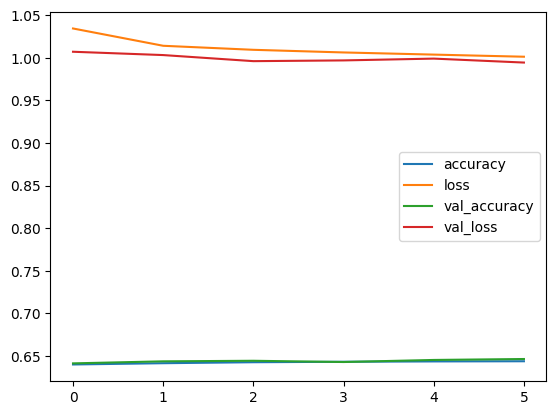

In [36]:
pd.DataFrame(history.history).plot()

In [37]:
from sklearn.metrics import ConfusionMatrixDisplay
y_test_predict = model.predict(x_test)
y_test_predict.shape

5330/5330 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step


(170537, 5)

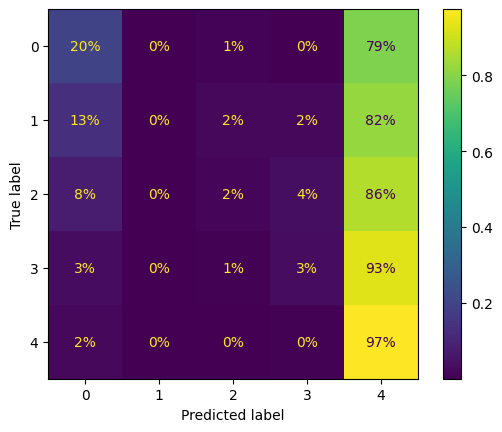

In [38]:
ConfusionMatrixDisplay.from_predictions(np.argmax(y_test, axis = -1),
                                       np.argmax(y_test_predict, axis = -1),
                                       normalize = 'true',
                                       values_format = '.0%')